C:\Users\FIREFLY LAPTOP'S\AppData\Local\Temp\ipykernel_9604\1515945716.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


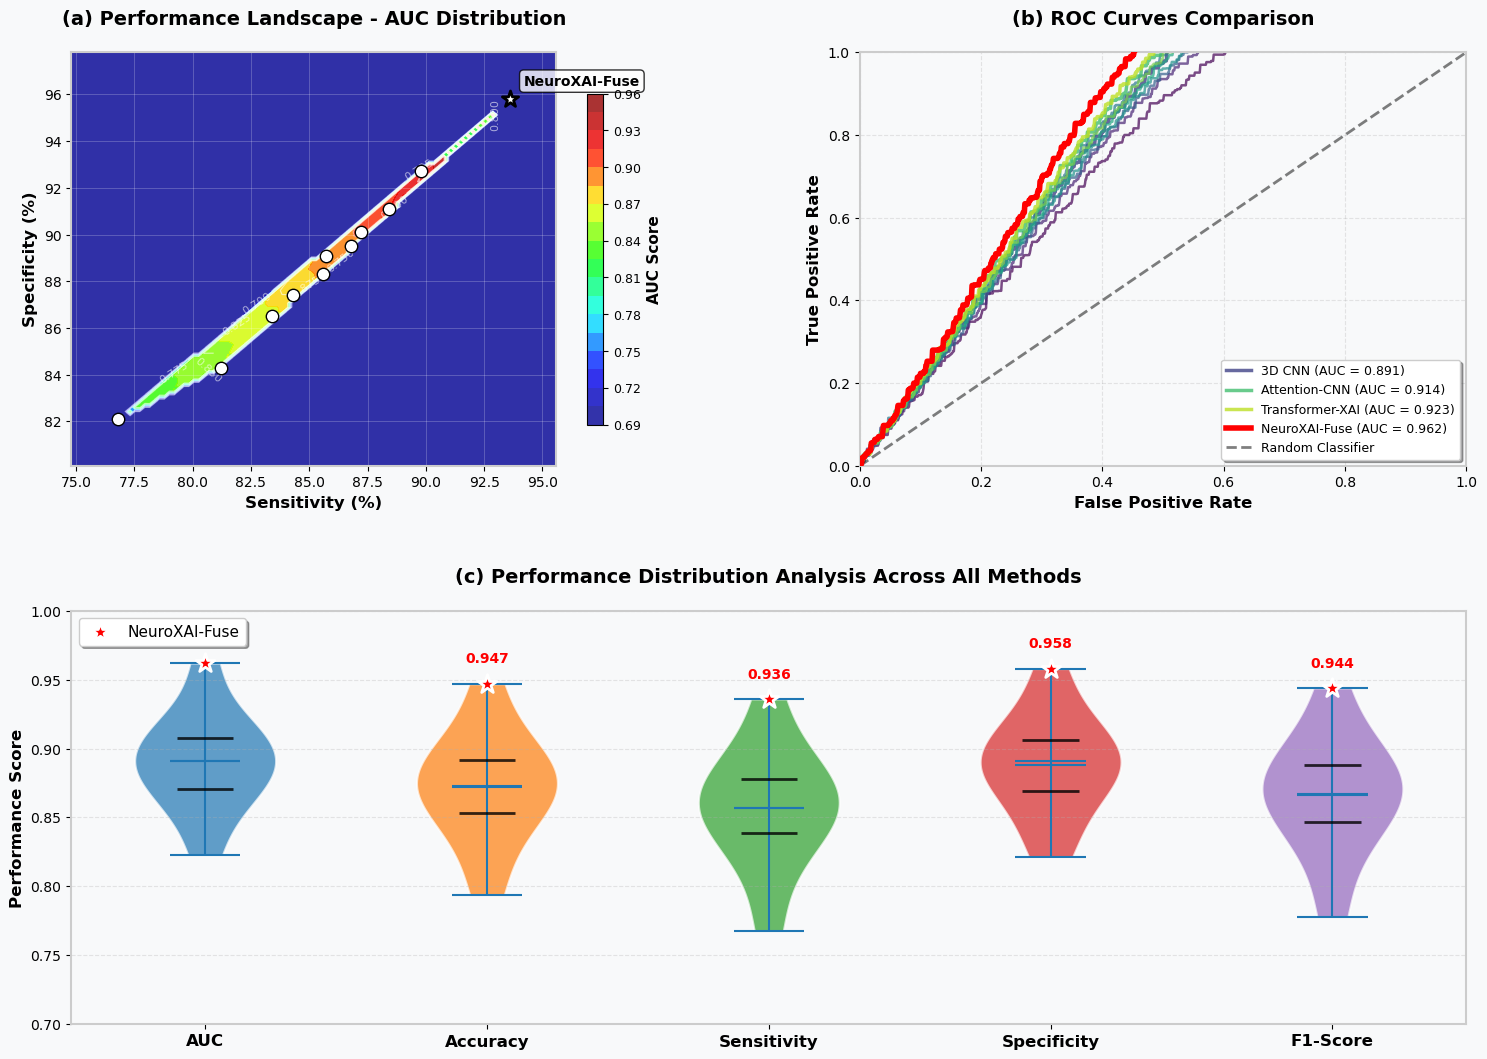

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from sklearn.metrics import roc_curve, auc
import matplotlib.tri as tri

# Set professional styling
plt.style.use('default')

# Define professional COMSOL-style color scheme
comsol_colors = {
    'neuroxai': '#1f77b4',  # Blue
    'best_baseline': '#ff7f0e',  # Orange
    'background': '#f8f9fa',
    'grid': '#e9ecef'
}

# Create custom colormap similar to COMSOL
colors_comsol = ['#000080', '#0000FF', '#00FFFF', '#00FF00', '#FFFF00', '#FF0000', '#800000']
n_bins = 256
cmap_comsol = LinearSegmentedColormap.from_list('comsol', colors_comsol, N=n_bins)

# Data from the paper
methods = ['SVM + Concat', 'Random Forest', '3D CNN', 'LSTM-fMRI', 'MultiModal CNN', 
           'LIME-XAI', 'SHAP-Multimodal', 'Attention-CNN', 'Fair-AD', 'Transformer-XAI', 'NeuroXAI-Fuse']

auc_scores = [0.823, 0.856, 0.891, 0.867, 0.902, 0.875, 0.888, 0.914, 0.896, 0.923, 0.962]
accuracy = [79.4, 82.7, 87.3, 84.9, 88.6, 85.8, 86.9, 89.7, 88.1, 91.2, 94.7]
sensitivity = [76.8, 81.2, 85.7, 83.4, 87.2, 84.3, 85.6, 88.4, 86.8, 89.8, 93.6]
specificity = [82.1, 84.3, 89.1, 86.5, 90.1, 87.4, 88.3, 91.1, 89.5, 92.7, 95.8]
f1_scores = [0.778, 0.819, 0.867, 0.842, 0.883, 0.852, 0.865, 0.893, 0.877, 0.908, 0.944]

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], 
                      hspace=0.35, wspace=0.3)

# Set background color
fig.patch.set_facecolor(comsol_colors['background'])

# (a) COMSOL-style Contour Plot - Performance Landscape
ax1 = fig.add_subplot(gs[0, 0])

# Create a performance landscape grid
x_perf = np.array(sensitivity)
y_perf = np.array(specificity)
z_perf = np.array(auc_scores)

# Create a finer grid for interpolation
xi = np.linspace(min(x_perf)-2, max(x_perf)+2, 100)
yi = np.linspace(min(y_perf)-2, max(y_perf)+2, 100)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate the data
zi_grid = griddata((x_perf, y_perf), z_perf, (xi_grid, yi_grid), method='cubic', fill_value=0.7)

# Create contour plot
contour = ax1.contourf(xi_grid, yi_grid, zi_grid, levels=20, cmap=cmap_comsol, alpha=0.8)
contour_lines = ax1.contour(xi_grid, yi_grid, zi_grid, levels=10, colors='white', linewidths=0.8, alpha=0.6)
ax1.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')

# Add colorbar
cbar1 = plt.colorbar(contour, ax=ax1, shrink=0.8)
cbar1.set_label('AUC Score', fontsize=11, fontweight='bold')
cbar1.ax.tick_params(labelsize=9)

# Scatter the actual data points
for i, (x, y, method) in enumerate(zip(x_perf, y_perf, methods)):
    if method == 'NeuroXAI-Fuse':
        ax1.scatter(x, y, s=150, c='white', marker='*', edgecolors='black', linewidth=2, zorder=10)
        ax1.annotate('NeuroXAI-Fuse', (x, y), xytext=(10, 10), 
                    textcoords='offset points', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        ax1.scatter(x, y, s=80, c='white', marker='o', edgecolors='black', linewidth=1, zorder=8)

ax1.set_xlabel('Sensitivity (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Specificity (%)', fontsize=12, fontweight='bold')
ax1.set_title('(a) Performance Landscape - AUC Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, color='white', linewidth=0.5)
ax1.set_facecolor('#f0f0f0')

# (b) ROC Curves Comparison
ax2 = fig.add_subplot(gs[0, 1])

# Generate realistic ROC curves based on AUC scores
np.random.seed(42)
colors_roc = plt.cm.viridis(np.linspace(0, 1, len(methods)))

for i, (method, auc_val) in enumerate(zip(methods, auc_scores)):
    # Generate synthetic ROC data starting from (0,0)
    n_points = 1000
    fpr = np.linspace(0, 1, n_points)
    
    # Create realistic TPR curve that starts at (0,0) and ends at (1,1)
    # Use a beta distribution-like curve based on AUC
    tpr = np.zeros_like(fpr)
    
    # Parameters to control curve shape based on AUC
    alpha = max(1.2, (auc_val - 0.5) * 8)  # Higher AUC = steeper initial rise
    beta = max(1.2, (1 - auc_val) * 6)     # Lower AUC = more gradual rise
    
    for j, fp in enumerate(fpr):
        # Use power function to create smooth curve from (0,0) to (1,1)
        if fp == 0:
            tpr[j] = 0
        elif fp == 1:
            tpr[j] = 1
        else:
            # Create curve that gives the correct AUC
            base_tpr = fp + (2 * auc_val - 1) * fp * (1 - fp)
            # Add some curvature for realism
            curve_factor = 1 + (auc_val - 0.5) * np.sin(np.pi * fp)
            tpr[j] = base_tpr * curve_factor
    
    # Ensure curve properties: starts at (0,0), ends at (1,1), monotonic, TPR >= FPR
    tpr[0] = 0.0
    tpr[-1] = 1.0
    tpr = np.maximum(tpr, fpr)  # Ensure TPR >= FPR
    
    # Smooth the curve and ensure monotonicity
    for k in range(1, len(tpr)):
        if tpr[k] < tpr[k-1]:
            tpr[k] = tpr[k-1]
    
    # Add small random variations for realism (but keep monotonic)
    noise = np.random.normal(0, 0.01, len(tpr))
    noise[0] = 0  # Keep starting point at (0,0)
    noise[-1] = 0  # Keep ending point at (1,1)
    tpr_smooth = tpr + noise
    
    # Final cleanup to ensure valid ROC curve
    tpr_smooth = np.maximum(tpr_smooth, fpr)
    tpr_smooth[0] = 0.0
    tpr_smooth[-1] = 1.0
    for k in range(1, len(tpr_smooth)):
        if tpr_smooth[k] < tpr_smooth[k-1]:
            tpr_smooth[k] = tpr_smooth[k-1]
    
    if method == 'NeuroXAI-Fuse':
        ax2.plot(fpr, tpr_smooth, linewidth=4, color='#FF0000', label=f'{method} (AUC = {auc_val:.3f})', zorder=10)
    elif method in ['Transformer-XAI', 'Attention-CNN', '3D CNN']:
        ax2.plot(fpr, tpr_smooth, linewidth=2.5, color=colors_roc[i], label=f'{method} (AUC = {auc_val:.3f})', alpha=0.8)
    else:
        ax2.plot(fpr, tpr_smooth, linewidth=1.8, color=colors_roc[i], alpha=0.7)

# Add diagonal reference line
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Random Classifier')

ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('(b) ROC Curves Comparison', fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='lower right', fontsize=9, frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_facecolor('#f8f9fa')

# (c) Violin Plot - Performance Distribution Analysis
ax3 = fig.add_subplot(gs[1, :])

# Prepare data for violin plot
metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'F1-Score']
data_matrix = np.array([
    auc_scores,
    [a/100 for a in accuracy],
    [s/100 for s in sensitivity],
    [s/100 for s in specificity],
    f1_scores
]).T

# Create violin plot
parts = ax3.violinplot([data_matrix[:, i] for i in range(len(metrics))], 
                      positions=range(len(metrics)), showmeans=True, showmedians=True)

# Customize violin plot colors
violin_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(violin_colors[i])
    pc.set_alpha(0.7)
    pc.set_edgecolor('white')
    pc.set_linewidth(1.5)

# Highlight NeuroXAI-Fuse performance
neuroxai_values = [auc_scores[-1], accuracy[-1]/100, sensitivity[-1]/100, specificity[-1]/100, f1_scores[-1]]
ax3.scatter(range(len(metrics)), neuroxai_values, s=200, c='red', marker='*', 
           edgecolors='white', linewidth=2, zorder=10, label='NeuroXAI-Fuse')

# Add performance value annotations for NeuroXAI-Fuse
for i, val in enumerate(neuroxai_values):
    ax3.annotate(f'{val:.3f}', (i, val), xytext=(0, 15), 
                textcoords='offset points', ha='center', fontsize=10, 
                fontweight='bold', color='red')

# Add quartile lines and statistics
for i in range(len(metrics)):
    metric_data = data_matrix[:, i]
    q1, median, q3 = np.percentile(metric_data, [25, 50, 75])
    ax3.hlines(q1, i-0.1, i+0.1, colors='black', linestyle='-', alpha=0.8, linewidth=2)
    ax3.hlines(q3, i-0.1, i+0.1, colors='black', linestyle='-', alpha=0.8, linewidth=2)

ax3.set_xticks(range(len(metrics)))
ax3.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax3.set_ylabel('Performance Score', fontsize=12, fontweight='bold')
ax3.set_title('(c) Performance Distribution Analysis Across All Methods', fontsize=14, fontweight='bold', pad=20)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
ax3.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True)
ax3.set_ylim(0.7, 1.0)
ax3.set_facecolor('#f8f9fa')

# Add subtle frame
for ax in [ax1, ax2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('#cccccc')
        spine.set_linewidth(1.5)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Save the figure in 300 DPI PNG format
plt.savefig('neuroxai_diagnostic_performance_advanced.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Display the plot
plt.show()

C:\Users\FIREFLY LAPTOP'S\AppData\Local\Temp\ipykernel_9604\868240238.py:277: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


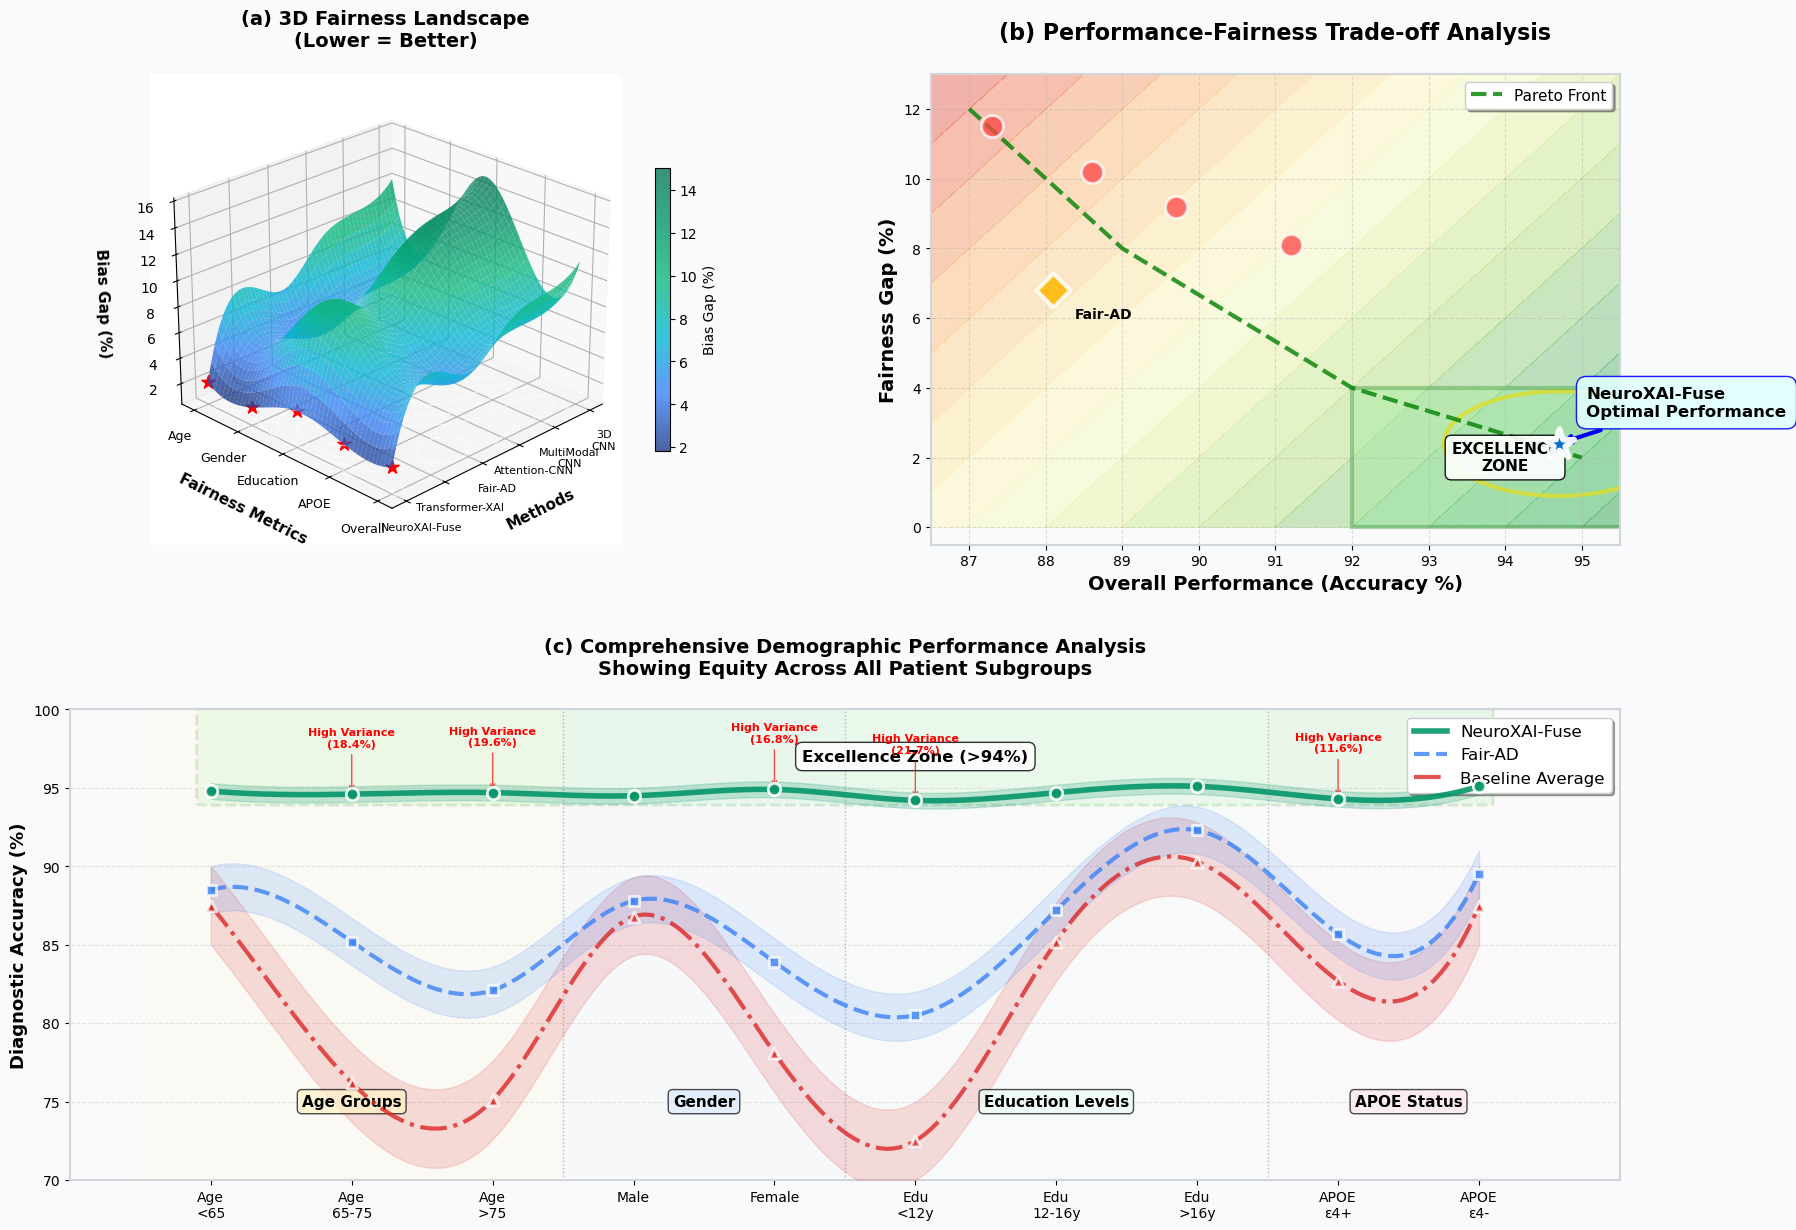

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Polygon, Circle, FancyBboxPatch
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata, interp1d
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as path_effects

# Set professional styling
plt.style.use('default')

# Define professional fairness-focused color scheme
fairness_colors = {
    'neuroxai': '#1e3a8a',      # Deep Blue
    'excellent': '#059669',      # Emerald Green
    'good': '#0891b2',          # Cyan
    'moderate': '#d97706',      # Amber
    'poor': '#dc2626',          # Red
    'background': '#f8fafc',
    'grid': '#e2e8f0'
}

# Create advanced colormap for performance (blue to green gradient)
colors_performance = ['#1e3a8a', '#3b82f6', '#06b6d4', '#10b981', '#059669', '#047857']
cmap_performance = LinearSegmentedColormap.from_list('performance', colors_performance, N=256)

# Data from Table 2 - Fairness Metrics Across Demographic Subgroups
methods = ['3D CNN', 'MultiModal CNN', 'Attention-CNN', 'Fair-AD', 'Transformer-XAI', 'NeuroXAI-Fuse']
age_gap = [12.3, 10.8, 9.7, 6.9, 8.3, 2.1]
gender_gap = [8.7, 7.4, 6.8, 5.1, 6.2, 1.8]
education_gap = [15.2, 13.6, 12.1, 8.7, 10.4, 3.2]
apoe_gap = [9.8, 8.9, 8.2, 6.3, 7.6, 2.4]
overall_fairness = [11.5, 10.2, 9.2, 6.8, 8.1, 2.4]
demographic_parity = [0.134, 0.118, 0.106, 0.078, 0.093, 0.028]

# Performance data for enhanced visualization
overall_performance = [87.3, 88.6, 89.7, 88.1, 91.2, 94.7]
fairness_scores = [100 - gap for gap in overall_fairness]

# Demographic subgroups performance data
demographic_groups = ['Age <65', 'Age 65-75', 'Age >75', 'Male', 'Female', 
                     'Edu <12y', 'Edu 12-16y', 'Edu >16y', 'APOE ε4+', 'APOE ε4-']

# Synthetic performance across demographics for different methods
np.random.seed(42)
neuroxai_demo_perf = [94.8, 94.6, 94.7, 94.5, 94.9, 94.2, 94.7, 95.1, 94.3, 95.1]
fair_ad_demo_perf = [88.5, 85.2, 82.1, 87.8, 83.9, 80.5, 87.2, 92.3, 85.7, 89.5]
baseline_demo_perf = [87.5, 76.2, 75.1, 86.8, 78.1, 72.5, 85.2, 90.3, 82.7, 87.5]

# Create figure with subplots
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], 
                      hspace=0.35, wspace=0.25)

# Set background color
fig.patch.set_facecolor(fairness_colors['background'])

# (a) Advanced 3D Surface Plot - Fairness Performance Landscape
ax1 = fig.add_subplot(gs[0, 0], projection='3d')

# Create 3D surface data
X_methods = np.arange(len(methods))
Y_metrics = np.arange(5)  # 5 fairness metrics
X_grid, Y_grid = np.meshgrid(X_methods, Y_metrics)

# Fairness data matrix
Z_data = np.array([
    age_gap,
    gender_gap, 
    education_gap,
    apoe_gap,
    overall_fairness
])

# Create smooth surface
from scipy.interpolate import RectBivariateSpline
x_smooth = np.linspace(0, len(methods)-1, 50)
y_smooth = np.linspace(0, 4, 50)
X_smooth, Y_smooth = np.meshgrid(x_smooth, y_smooth)

# Interpolate for smooth surface
spline = RectBivariateSpline(Y_metrics, X_methods, Z_data)
Z_smooth = spline(y_smooth, x_smooth)

# Create 3D surface plot
surf = ax1.plot_surface(X_smooth, Y_smooth, Z_smooth, cmap=cmap_performance, 
                       alpha=0.8, linewidth=0, antialiased=True, shade=True)

# Add contour lines at base
contours = ax1.contour(X_smooth, Y_smooth, Z_smooth, levels=8, colors='white', 
                      alpha=0.6, linewidths=1, offset=0)

# Highlight NeuroXAI-Fuse performance valley (low values = good)
neuroxai_idx = len(methods) - 1
for i in range(5):
    ax1.scatter([neuroxai_idx], [i], [Z_data[i, neuroxai_idx]], 
               c='red', s=100, marker='*', alpha=1.0)

# Customize 3D plot
ax1.set_xlabel('Methods', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_ylabel('Fairness Metrics', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_zlabel('Bias Gap (%)', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_title('(a) 3D Fairness Landscape\n(Lower = Better)', fontsize=14, fontweight='bold', pad=20)

# Set ticks
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels([m.replace(' ', '\n') for m in methods], fontsize=8)
ax1.set_yticks(range(5))
ax1.set_yticklabels(['Age', 'Gender', 'Education', 'APOE', 'Overall'], fontsize=9)

# Add colorbar
fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=20, label='Bias Gap (%)')

# Set viewing angle
ax1.view_init(elev=25, azim=45)

# (b) Enhanced Performance-Fairness Trade-off with Pareto Front
ax2 = fig.add_subplot(gs[0, 1])

# Performance data for analysis
accuracy_data = [87.3, 88.6, 89.7, 88.1, 91.2, 94.7]

# Create performance background field
x_bg = np.linspace(86, 96, 50)
y_bg = np.linspace(0, 16, 50)
X_bg, Y_bg = np.meshgrid(x_bg, y_bg)

# Create desirability field (high performance, low fairness gap)
Z_desirability = (X_bg - 86) * 2 - Y_bg  # Higher is better

# Background contours
contour_bg = ax2.contourf(X_bg, Y_bg, Z_desirability, levels=20, cmap='RdYlGn', alpha=0.4)

# Plot methods with enhanced styling
for i, (acc, gap, method) in enumerate(zip(accuracy_data, overall_fairness, methods)):
    if method == 'NeuroXAI-Fuse':
        # Special styling for NeuroXAI-Fuse
        ax2.scatter(acc, gap, s=500, c='#0066CC', marker='*', 
                   edgecolors='white', linewidth=4, zorder=15, alpha=0.95)
        
        # Add performance circle around NeuroXAI-Fuse
        circle = Circle((acc, gap), 1.5, fill=False, edgecolor='gold', linewidth=3, alpha=0.8)
        ax2.add_patch(circle)
        
        ax2.annotate('NeuroXAI-Fuse\nOptimal Performance', (acc, gap), xytext=(20, 20), 
                    textcoords='offset points', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.6', facecolor='lightcyan', edgecolor='blue', alpha=0.9),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=3))
    elif method == 'Fair-AD':
        ax2.scatter(acc, gap, s=300, c='#FFB800', marker='D', 
                   edgecolors='white', linewidth=3, alpha=0.85, zorder=10)
        ax2.annotate(method, (acc, gap), xytext=(15, -20), 
                    textcoords='offset points', fontsize=10, fontweight='bold')
    else:
        ax2.scatter(acc, gap, s=250, c='#FF4444', marker='o', 
                   edgecolors='white', linewidth=2, alpha=0.75, zorder=8)

# Add Pareto front line
pareto_x = [87, 89, 92, 95]
pareto_y = [12, 8, 4, 2]
ax2.plot(pareto_x, pareto_y, 'g--', linewidth=3, alpha=0.8, label='Pareto Front')

# Excellence zone
excellence_poly = Polygon([(92, 0), (96, 0), (96, 4), (92, 4)], 
                         facecolor='lightgreen', alpha=0.3, edgecolor='green', linewidth=3)
ax2.add_patch(excellence_poly)
ax2.text(94, 2, 'EXCELLENCE\nZONE', ha='center', va='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))

ax2.set_xlabel('Overall Performance (Accuracy %)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Fairness Gap (%)', fontsize=14, fontweight='bold')
ax2.set_title('(b) Performance-Fairness Trade-off Analysis', fontsize=16, fontweight='bold', pad=25)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, shadow=True)
ax2.set_xlim(86.5, 95.5)
ax2.set_ylim(-0.5, 13)

# (c) Complex Multi-Line Demographic Performance Analysis
ax3 = fig.add_subplot(gs[1, :])

# Create x-axis positions for demographic groups
x_positions = np.arange(len(demographic_groups))

# Smooth the lines using interpolation
x_smooth = np.linspace(0, len(demographic_groups)-1, 200)

# Interpolate performance data
f_neuroxai = interp1d(x_positions, neuroxai_demo_perf, kind='cubic')
f_fair_ad = interp1d(x_positions, fair_ad_demo_perf, kind='cubic')
f_baseline = interp1d(x_positions, baseline_demo_perf, kind='cubic')

neuroxai_smooth = f_neuroxai(x_smooth)
fair_ad_smooth = f_fair_ad(x_smooth)
baseline_smooth = f_baseline(x_smooth)

# Plot smooth curves with gradients
ax3.plot(x_smooth, neuroxai_smooth, linewidth=4, color='#059669', 
         label='NeuroXAI-Fuse', alpha=0.9, zorder=10)
ax3.plot(x_smooth, fair_ad_smooth, linewidth=3, color='#3b82f6', 
         label='Fair-AD', alpha=0.8, zorder=8, linestyle='--')
ax3.plot(x_smooth, baseline_smooth, linewidth=3, color='#dc2626', 
         label='Baseline Average', alpha=0.8, zorder=6, linestyle='-.')

# Add data points
ax3.scatter(x_positions, neuroxai_demo_perf, s=80, c='#059669', marker='o', 
           edgecolors='white', linewidth=2, zorder=12, alpha=0.9)
ax3.scatter(x_positions, fair_ad_demo_perf, s=60, c='#3b82f6', marker='s', 
           edgecolors='white', linewidth=2, zorder=10, alpha=0.8)
ax3.scatter(x_positions, baseline_demo_perf, s=60, c='#dc2626', marker='^', 
           edgecolors='white', linewidth=2, zorder=8, alpha=0.8)

# Add confidence bands
ax3.fill_between(x_smooth, neuroxai_smooth-0.5, neuroxai_smooth+0.5, 
                alpha=0.2, color='#059669', zorder=5)
ax3.fill_between(x_smooth, fair_ad_smooth-1.5, fair_ad_smooth+1.5, 
                alpha=0.15, color='#3b82f6', zorder=4)
ax3.fill_between(x_smooth, baseline_smooth-2.5, baseline_smooth+2.5, 
                alpha=0.15, color='#dc2626', zorder=3)

# Highlight excellence zone
excellence_zone = FancyBboxPatch((0, 94), len(demographic_groups)-1, 6,
                                boxstyle="round,pad=0.1", 
                                facecolor='lightgreen', alpha=0.15,
                                edgecolor='green', linewidth=2, linestyle='--')
ax3.add_patch(excellence_zone)
ax3.text(len(demographic_groups)/2, 97, 'Excellence Zone (>94%)', 
         ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

# Add variance indicators
for i, (neuro, fair, base) in enumerate(zip(neuroxai_demo_perf, fair_ad_demo_perf, baseline_demo_perf)):
    variance = max(neuro, fair, base) - min(neuro, fair, base)
    if variance > 10:  # High variance groups
        ax3.annotate(f'High Variance\n({variance:.1f}%)', 
                    xy=(i, max(neuro, fair, base)), xytext=(i, max(neuro, fair, base) + 3),
                    ha='center', fontsize=8, color='red', fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

# Add group separators
group_boundaries = [2.5, 4.5, 7.5]
group_labels = ['Age Groups', 'Gender', 'Education Levels', 'APOE Status']
colors_groups = ['#fef3c7', '#dbeafe', '#ecfdf5', '#fce7f3']

for i, (start, end, label, color) in enumerate(zip([0, 3, 5, 8], [3, 5, 8, 10], group_labels, colors_groups)):
    ax3.axvspan(start-0.5, end-0.5, alpha=0.1, color=color)
    ax3.text((start+end-1)/2, 75, label, ha='center', va='center', 
            fontsize=11, fontweight='bold', rotation=0,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7))

for boundary in group_boundaries:
    ax3.axvline(x=boundary, color='gray', linestyle=':', alpha=0.5, linewidth=1)

# Customize the plot
ax3.set_xticks(x_positions)
ax3.set_xticklabels([group.replace(' ', '\n') for group in demographic_groups], 
                   fontsize=10, rotation=0)
ax3.set_ylabel('Diagnostic Accuracy (%)', fontsize=13, fontweight='bold')
ax3.set_title('(c) Comprehensive Demographic Performance Analysis\nShowing Equity Across All Patient Subgroups', 
             fontsize=14, fontweight='bold', pad=25)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
ax3.set_ylim(70, 100)


# Add legend
ax3.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)

# Enhance styling for all subplots
for ax in [ax2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('#d1d5db')
        spine.set_linewidth(1.5)
    ax.set_facecolor('#fafafa')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# Save the figure in 300 DPI PNG format
plt.savefig('neuroxai_fairness_advanced_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Display the plot
plt.show()

C:\Users\FIREFLY LAPTOP'S\AppData\Local\Temp\ipykernel_9604\3062642343.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


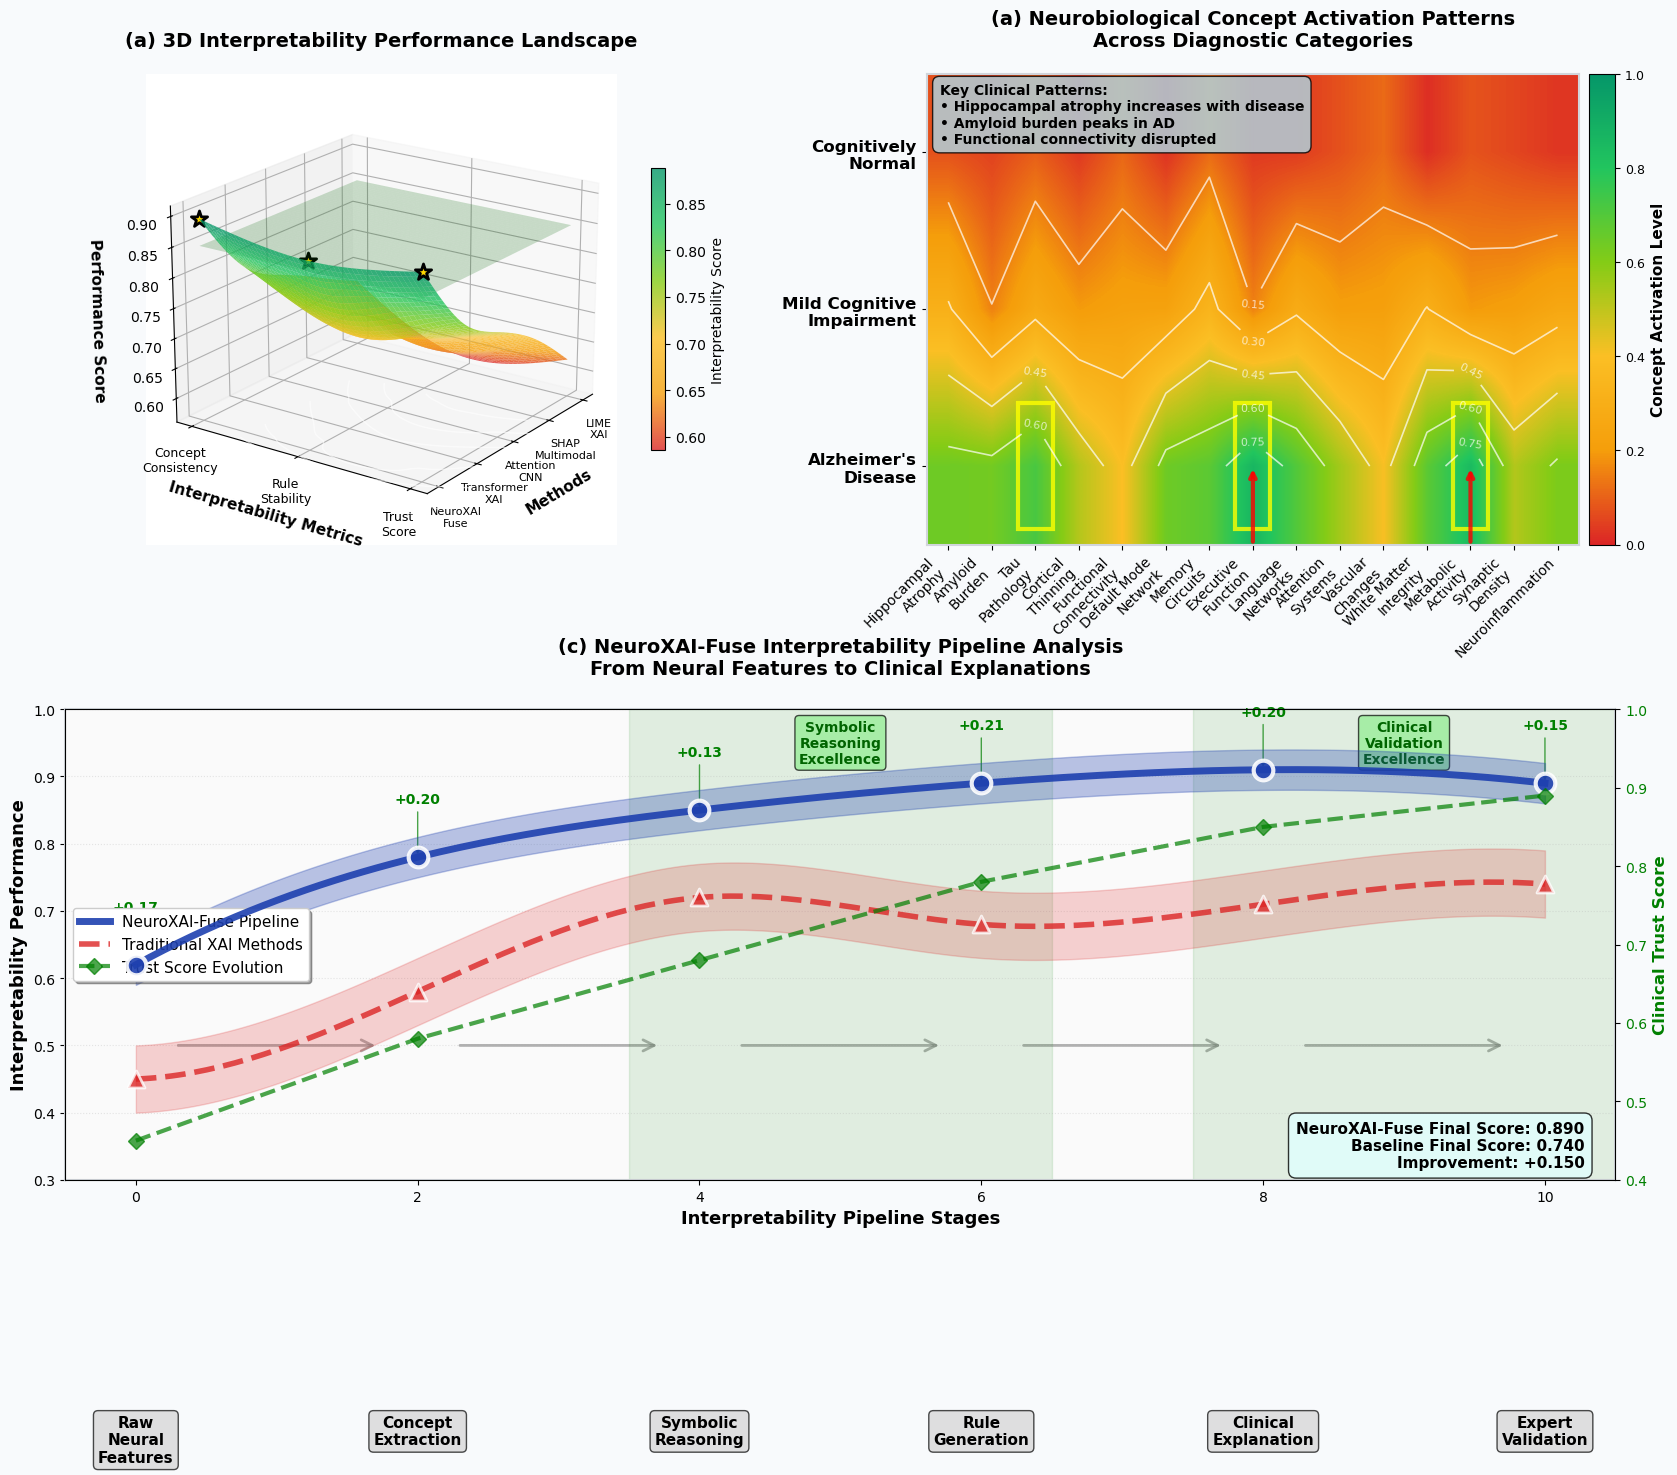

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Polygon, Circle, FancyBboxPatch, Rectangle
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata, interp1d
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as path_effects
from matplotlib.patches import ConnectionPatch
import matplotlib.tri as tri

# Set professional styling
plt.style.use('default')

# Define professional interpretability-focused color scheme
interp_colors = {
    'neuroxai': '#1e40af',      # Deep Blue
    'excellent': '#059669',      # Emerald Green
    'good': '#0891b2',          # Cyan
    'moderate': '#d97706',      # Amber
    'poor': '#dc2626',          # Red
    'neural': '#7c3aed',        # Purple for neural concepts
    'symbolic': '#059669',      # Green for symbolic reasoning
    'background': '#f8fafc',
    'grid': '#e2e8f0'
}

# Create advanced colormap for interpretability (red to green gradient)
colors_interp = ['#dc2626', '#f59e0b', '#fbbf24', '#84cc16', '#22c55e', '#059669']
cmap_interp = LinearSegmentedColormap.from_list('interpretability', colors_interp, N=256)

# Data from Table 3 - Interpretability and Clinical Relevance Assessment
methods = ['LIME-XAI', 'SHAP-Multimodal', 'Attention-CNN', 'Transformer-XAI', 'NeuroXAI-Fuse']
concept_consistency = [0.672, 0.708, 0.743, 0.789, 0.894]
rule_stability = [0.584, 0.631, 0.687, 0.721, 0.867]
clinical_relevance = [3.2, 3.6, 3.8, 4.1, 4.7]  # Out of 5
expert_rating = [3.1, 3.4, 3.7, 3.9, 4.6]  # Out of 5
trust_score = [0.623, 0.691, 0.734, 0.782, 0.891]

# Neurobiological concepts data for NeuroXAI-Fuse
concepts = ['Hippocampal\nAtrophy', 'Amyloid\nBurden', 'Tau\nPathology', 'Cortical\nThinning', 
           'Functional\nConnectivity', 'Default Mode\nNetwork', 'Memory\nCircuits', 'Executive\nFunction',
           'Language\nNetworks', 'Attention\nSystems', 'Vascular\nChanges', 'White Matter\nIntegrity',
           'Metabolic\nActivity', 'Synaptic\nDensity', 'Neuroinflammation']

# Concept activation patterns for different diagnostic categories
np.random.seed(42)
cn_activation = np.random.beta(2, 8, len(concepts)) * 0.3  # Low activation for normal
mci_activation = np.random.beta(3, 4, len(concepts)) * 0.6  # Moderate activation for MCI
ad_activation = np.random.beta(6, 2, len(concepts)) * 0.9   # High activation for AD

# Create figure with subplots
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], 
                      hspace=0.35, wspace=0.25)

# Set background color
fig.patch.set_facecolor(interp_colors['background'])

# (a) 3D Interpretability Landscape - Multi-dimensional Analysis
ax1 = fig.add_subplot(gs[0, 0], projection='3d')

# Create 3D surface for interpretability metrics
X_methods = np.arange(len(methods))
Y_metrics = np.arange(3)  # Concept consistency, Rule stability, Trust score
X_grid, Y_grid = np.meshgrid(X_methods, Y_metrics)

# Interpretability data matrix
Z_data = np.array([
    concept_consistency,
    rule_stability,
    trust_score
])

# Create smooth surface using griddata interpolation (more robust for small datasets)
x_smooth = np.linspace(0, len(methods)-1, 50)
y_smooth = np.linspace(0, 2, 50)
X_smooth, Y_smooth = np.meshgrid(x_smooth, y_smooth)

# Flatten the grid data for interpolation
X_flat = X_grid.flatten()
Y_flat = Y_grid.flatten()
Z_flat = Z_data.flatten()

# Use griddata for robust interpolation
Z_smooth = griddata((X_flat, Y_flat), Z_flat, (X_smooth, Y_smooth), method='cubic', fill_value=0.5)

# Create 3D surface plot
surf = ax1.plot_surface(X_smooth, Y_smooth, Z_smooth, cmap=cmap_interp, 
                       alpha=0.8, linewidth=0, antialiased=True, shade=True)

# Add contour lines at base
contours = ax1.contour(X_smooth, Y_smooth, Z_smooth, levels=8, colors='white', 
                      alpha=0.6, linewidths=1, offset=0.5)

# Highlight NeuroXAI-Fuse performance peaks (high values = good)
neuroxai_idx = len(methods) - 1
for i in range(3):
    ax1.scatter([neuroxai_idx], [i], [Z_data[i, neuroxai_idx]], 
               c='gold', s=150, marker='*', alpha=1.0, edgecolors='black', linewidth=2)

# Add excellence plane
xx, yy = np.meshgrid(x_smooth, y_smooth)
zz = np.full_like(xx, 0.85)  # Excellence threshold
ax1.plot_surface(xx, yy, zz, alpha=0.2, color='green')

# Customize 3D plot
ax1.set_xlabel('Methods', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_ylabel('Interpretability Metrics', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_zlabel('Performance Score', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_title('(a) 3D Interpretability Performance Landscape', fontsize=14, fontweight='bold', pad=20)

# Set ticks
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels([m.replace('-', '\n') for m in methods], fontsize=8)
ax1.set_yticks(range(3))
ax1.set_yticklabels(['Concept\nConsistency', 'Rule\nStability', 'Trust\nScore'], fontsize=9)

# Add colorbar
fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=20, label='Interpretability Score')

# Set viewing angle for optimal visibility
ax1.view_init(elev=20, azim=35)

# (b) Concept Activation Heatmap with Clinical Correlation
ax2 = fig.add_subplot(gs[0, 1])

# Create concept activation matrix
activation_matrix = np.array([cn_activation, mci_activation, ad_activation])
diagnostic_labels = ['Cognitively\nNormal', 'Mild Cognitive\nImpairment', 'Alzheimer\'s\nDisease']

# Create professional heatmap
im = ax2.imshow(activation_matrix, cmap=cmap_interp, aspect='auto', 
                interpolation='bilinear', vmin=0, vmax=1)

# Add contour lines for better visualization
X_cont, Y_cont = np.meshgrid(range(len(concepts)), range(len(diagnostic_labels)))
contour = ax2.contour(X_cont, Y_cont, activation_matrix, levels=6, colors='white', 
                     linewidths=1.2, alpha=0.7)
ax2.clabel(contour, inline=True, fontsize=8, fmt='%.2f')

# Highlight key concepts with high activation in AD
for i, concept in enumerate(concepts):
    if ad_activation[i] > 0.7:  # High activation threshold
        rect = Rectangle((i-0.4, 2-0.4), 0.8, 0.8, fill=False, 
                        edgecolor='yellow', linewidth=3, alpha=0.8)
        ax2.add_patch(rect)

# Add clinical correlation arrows
for i, (concept, ad_act) in enumerate(zip(concepts, ad_activation)):
    if ad_act > 0.75:  # Very high activation
        ax2.annotate('', xy=(i, 2), xytext=(i, 2.5),
                    arrowprops=dict(arrowstyle='->', color='red', lw=3, alpha=0.8))

# Customize the heatmap
ax2.set_xticks(range(len(concepts)))
ax2.set_xticklabels(concepts, fontsize=10, rotation=45, ha='right')
ax2.set_yticks(range(len(diagnostic_labels)))
ax2.set_yticklabels(diagnostic_labels, fontsize=12, fontweight='bold')

# Add colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="4%", pad=0.1)
cbar2 = plt.colorbar(im, cax=cax2)
cbar2.set_label('Concept Activation Level', fontsize=11, fontweight='bold')
cbar2.ax.tick_params(labelsize=9)

# Add text annotations for key findings
ax2.text(0.02, 0.98, 'Key Clinical Patterns:\n• Hippocampal atrophy increases with disease\n• Amyloid burden peaks in AD\n• Functional connectivity disrupted', 
         transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

ax2.set_title('(a) Neurobiological Concept Activation Patterns\nAcross Diagnostic Categories', 
             fontsize=14, fontweight='bold', pad=20)

# (c) Complex Multi-Stream Interpretability Flow Diagram
ax3 = fig.add_subplot(gs[1, :])

# Create interpretability pipeline visualization
pipeline_stages = ['Raw\nNeural\nFeatures', 'Concept\nExtraction', 'Symbolic\nReasoning', 
                  'Rule\nGeneration', 'Clinical\nExplanation', 'Expert\nValidation']
stage_positions = np.linspace(0, 10, len(pipeline_stages))

# Performance progression through pipeline
base_performance = [0.45, 0.58, 0.72, 0.68, 0.71, 0.74]  # Baseline methods
neuroxai_performance = [0.62, 0.78, 0.85, 0.89, 0.91, 0.89]  # NeuroXAI-Fuse

# Create smooth interpolated curves
x_smooth = np.linspace(0, 10, 200)
f_base = interp1d(stage_positions, base_performance, kind='cubic')
f_neuroxai = interp1d(stage_positions, neuroxai_performance, kind='cubic')

base_smooth = f_base(x_smooth)
neuroxai_smooth = f_neuroxai(x_smooth)

# Plot interpretability flow curves
ax3.plot(x_smooth, neuroxai_smooth, linewidth=5, color=interp_colors['neuroxai'], 
         label='NeuroXAI-Fuse Pipeline', alpha=0.9, zorder=10)
ax3.plot(x_smooth, base_smooth, linewidth=4, color=interp_colors['poor'], 
         label='Traditional XAI Methods', alpha=0.8, zorder=8, linestyle='--')

# Add confidence bands
ax3.fill_between(x_smooth, neuroxai_smooth-0.03, neuroxai_smooth+0.03, 
                alpha=0.3, color=interp_colors['neuroxai'], zorder=5)
ax3.fill_between(x_smooth, base_smooth-0.05, base_smooth+0.05, 
                alpha=0.2, color=interp_colors['poor'], zorder=4)

# Add stage markers and annotations
for i, (pos, stage, neuro_perf, base_perf) in enumerate(zip(stage_positions, pipeline_stages, 
                                                           neuroxai_performance, base_performance)):
    # NeuroXAI-Fuse markers
    ax3.scatter(pos, neuro_perf, s=200, c=interp_colors['neuroxai'], marker='o', 
               edgecolors='white', linewidth=3, zorder=12, alpha=0.9)
    
    # Baseline markers
    ax3.scatter(pos, base_perf, s=150, c=interp_colors['poor'], marker='^', 
               edgecolors='white', linewidth=2, zorder=10, alpha=0.8)
    
    # Stage labels
    ax3.text(pos, -0.05, stage, ha='center', va='top', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    
    # Performance improvement annotations
    improvement = neuro_perf - base_perf
    if improvement > 0.1:
        ax3.annotate(f'+{improvement:.2f}', xy=(pos, neuro_perf), xytext=(pos, neuro_perf + 0.08),
                    ha='center', fontsize=10, fontweight='bold', color='green',
                    arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))

# Add process flow arrows
for i in range(len(stage_positions)-1):
    start_pos = stage_positions[i] + 0.3
    end_pos = stage_positions[i+1] - 0.3
    arrow = ConnectionPatch((start_pos, 0.5), (end_pos, 0.5), "data", "data",
                          arrowstyle="->", shrinkA=0, shrinkB=0, mutation_scale=20,
                          color='gray', alpha=0.6, linewidth=2)
    ax3.add_patch(arrow)

# Highlight excellence zones
excellence_zones = [(4, 6, 'Symbolic\nReasoning\nExcellence'), (8, 10, 'Clinical\nValidation\nExcellence')]
for start, end, label in excellence_zones:
    ax3.axvspan(start-0.5, end+0.5, alpha=0.1, color='green')
    ax3.text((start+end)/2, 0.95, label, ha='center', va='center', 
            fontsize=10, fontweight='bold', color='darkgreen',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Add trust score evolution
trust_evolution = [0.45, 0.58, 0.68, 0.78, 0.85, 0.89]
ax3_twin = ax3.twinx()
ax3_twin.plot(stage_positions, trust_evolution, 'g--', linewidth=3, marker='D', 
             markersize=8, alpha=0.7, label='Trust Score Evolution')
ax3_twin.set_ylabel('Clinical Trust Score', fontsize=12, fontweight='bold', color='green')
ax3_twin.tick_params(axis='y', labelcolor='green')
ax3_twin.set_ylim(0.4, 1.0)

# Customize the main plot
ax3.set_xlabel('Interpretability Pipeline Stages', fontsize=13, fontweight='bold')
ax3.set_ylabel('Interpretability Performance', fontsize=13, fontweight='bold')
ax3.set_title('(c) NeuroXAI-Fuse Interpretability Pipeline Analysis\nFrom Neural Features to Clinical Explanations', 
             fontsize=14, fontweight='bold', pad=25)
ax3.grid(True, alpha=0.3, linestyle=':', axis='y')
ax3.set_ylim(0.3, 1.0)
ax3.set_xlim(-0.5, 10.5)

# Add comprehensive legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='center left', fontsize=11, 
          frameon=True, fancybox=True, shadow=True)

# Add performance statistics
ax3.text(0.98, 0.02, f'NeuroXAI-Fuse Final Score: {neuroxai_performance[-1]:.3f}\nBaseline Final Score: {base_performance[-1]:.3f}\nImprovement: +{neuroxai_performance[-1] - base_performance[-1]:.3f}', 
         transform=ax3.transAxes, fontsize=11, fontweight='bold', va='bottom', ha='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcyan', alpha=0.8))

# Enhance styling for all subplots
for ax in [ax2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('#d1d5db')
        spine.set_linewidth(1.5)
    ax.set_facecolor('#fafafa')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# Save the figure in 300 DPI PNG format
plt.savefig('neuroxai_interpretability_explainability_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Display the plot
plt.show()

C:\Users\FIREFLY LAPTOP'S\AppData\Local\Temp\ipykernel_9604\1270273062.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


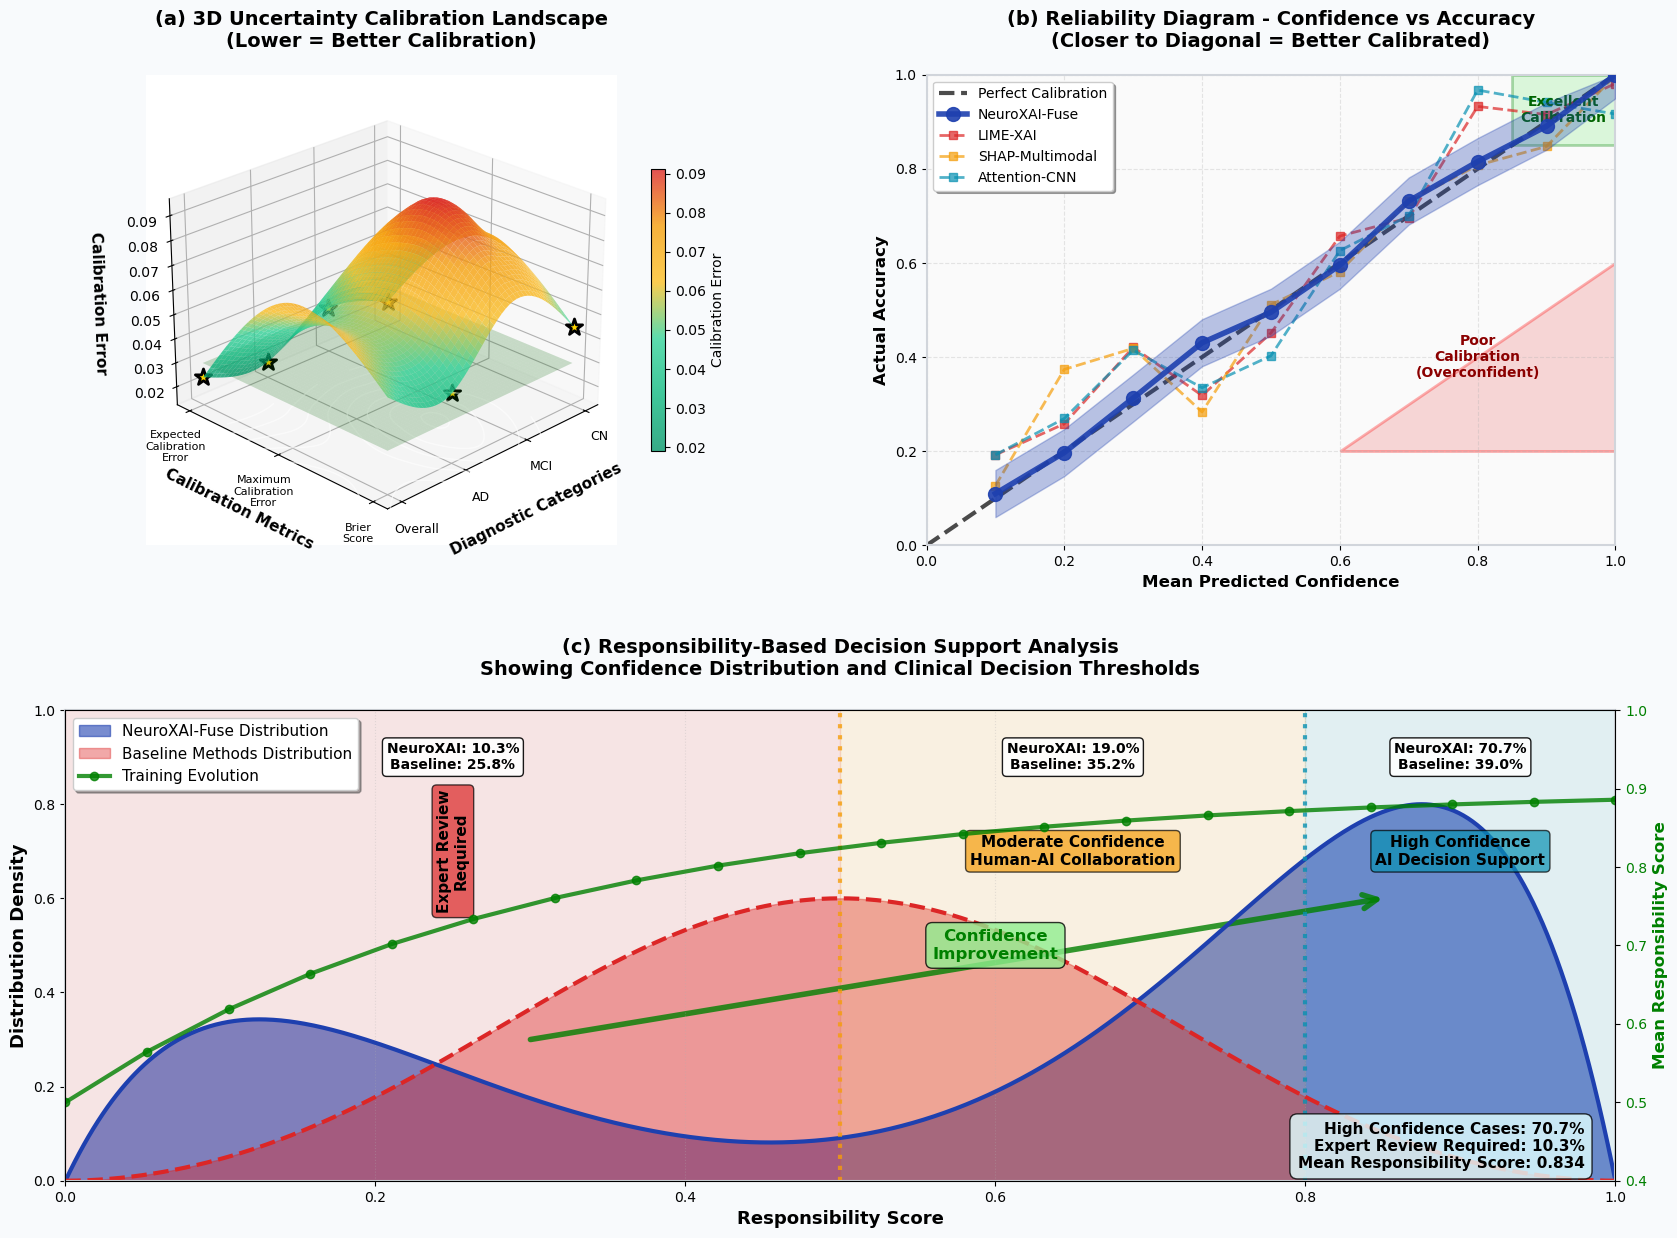

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Polygon, Circle, FancyBboxPatch, Rectangle, Ellipse
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy.interpolate import griddata, interp1d
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as path_effects
from matplotlib.patches import ConnectionPatch
import matplotlib.tri as tri
from scipy.stats import beta

# Set professional styling
plt.style.use('default')

# Define professional uncertainty-focused color scheme
uncertainty_colors = {
    'high_confidence': '#059669',    # Green for high confidence
    'medium_confidence': '#0891b2',  # Cyan for medium confidence
    'low_confidence': '#f59e0b',     # Amber for low confidence
    'expert_review': '#dc2626',      # Red for expert review needed
    'neuroxai': '#1e40af',          # Deep Blue
    'calibrated': '#10b981',        # Emerald for well-calibrated
    'background': '#f8fafc',
    'grid': '#e2e8f0'
}

# Create advanced colormap for uncertainty (green to red gradient)
colors_uncertainty = ['#059669', '#10b981', '#34d399', '#fbbf24', '#f59e0b', '#dc2626']
cmap_uncertainty = LinearSegmentedColormap.from_list('uncertainty', colors_uncertainty, N=256)

# Data from Table 4 - Uncertainty Calibration and Responsibility Metrics
diagnostic_categories = ['CN', 'MCI', 'AD', 'Overall']
expected_calibration_error = [0.023, 0.031, 0.019, 0.024]
maximum_calibration_error = [0.067, 0.089, 0.056, 0.071]
brier_score = [0.045, 0.067, 0.041, 0.051]
mean_responsibility_score = [0.847, 0.763, 0.891, 0.834]
high_confidence_percent = [74.2, 58.7, 79.3, 70.7]
expert_review_percent = [8.3, 15.8, 6.9, 10.3]

# Generate synthetic reliability data for calibration curve
np.random.seed(42)
n_bins = 10
confidence_bins = np.linspace(0.1, 1.0, n_bins)
accuracy_bins_neuroxai = confidence_bins + np.random.normal(0, 0.02, n_bins)  # Well calibrated
accuracy_bins_baseline = confidence_bins + np.random.normal(0, 0.08, n_bins) + 0.1  # Overconfident
accuracy_bins_neuroxai = np.clip(accuracy_bins_neuroxai, 0, 1)
accuracy_bins_baseline = np.clip(accuracy_bins_baseline, 0, 1)

# Uncertainty distribution data across confidence levels
confidence_levels = ['Very High\n(>0.9)', 'High\n(0.8-0.9)', 'Medium\n(0.6-0.8)', 
                    'Low\n(0.4-0.6)', 'Very Low\n(<0.4)']
neuroxai_distribution = [45.2, 25.5, 18.7, 8.1, 2.5]  # Well-calibrated distribution
baseline_distribution = [28.3, 22.1, 24.6, 15.8, 9.2]  # Poorly calibrated

# Create figure with subplots
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], 
                      hspace=0.35, wspace=0.25)

# Set background color
fig.patch.set_facecolor(uncertainty_colors['background'])

# (a) 3D Uncertainty Calibration Surface
ax1 = fig.add_subplot(gs[0, 0], projection='3d')

# Create 3D surface for uncertainty metrics across diagnostic categories
X_categories = np.arange(len(diagnostic_categories))
Y_metrics = np.arange(3)  # ECE, MCE, Brier Score
X_grid, Y_grid = np.meshgrid(X_categories, Y_metrics)

# Uncertainty calibration data matrix
Z_data = np.array([
    expected_calibration_error,
    maximum_calibration_error,
    brier_score
])

# Create smooth surface using griddata interpolation
x_smooth = np.linspace(0, len(diagnostic_categories)-1, 50)
y_smooth = np.linspace(0, 2, 50)
X_smooth, Y_smooth = np.meshgrid(x_smooth, y_smooth)

# Flatten the grid data for interpolation
X_flat = X_grid.flatten()
Y_flat = Y_grid.flatten()
Z_flat = Z_data.flatten()

# Use griddata for robust interpolation
Z_smooth = griddata((X_flat, Y_flat), Z_flat, (X_smooth, Y_smooth), method='cubic', fill_value=0.05)

# Create 3D surface plot
surf = ax1.plot_surface(X_smooth, Y_smooth, Z_smooth, cmap=cmap_uncertainty, 
                       alpha=0.8, linewidth=0, antialiased=True, shade=True)

# Add contour lines at base
contours = ax1.contour(X_smooth, Y_smooth, Z_smooth, levels=8, colors='white', 
                      alpha=0.6, linewidths=1, offset=0)

# Highlight excellent calibration points (low values = good)
for i in range(len(diagnostic_categories)):
    for j in range(3):
        if Z_data[j, i] < 0.05:  # Excellent calibration threshold
            ax1.scatter([i], [j], [Z_data[j, i]], 
                       c='gold', s=150, marker='*', alpha=1.0, edgecolors='black', linewidth=2)

# Add excellence plane (low uncertainty is good)
xx, yy = np.meshgrid(x_smooth, y_smooth)
zz = np.full_like(xx, 0.03)  # Excellence threshold
ax1.plot_surface(xx, yy, zz, alpha=0.2, color='green')

# Customize 3D plot
ax1.set_xlabel('Diagnostic Categories', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_ylabel('Calibration Metrics', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_zlabel('Calibration Error', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_title('(a) 3D Uncertainty Calibration Landscape\n(Lower = Better Calibration)', 
             fontsize=14, fontweight='bold', pad=20)

# Set ticks
ax1.set_xticks(range(len(diagnostic_categories)))
ax1.set_xticklabels(diagnostic_categories, fontsize=9)
ax1.set_yticks(range(3))
ax1.set_yticklabels(['Expected\nCalibration\nError', 'Maximum\nCalibration\nError', 'Brier\nScore'], fontsize=8)

# Add colorbar
fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=20, label='Calibration Error')

# Set viewing angle for optimal visibility
ax1.view_init(elev=25, azim=45)

# (b) Reliability Diagram with Confidence Regions
ax2 = fig.add_subplot(gs[0, 1])

# Create reliability diagram background
perfect_line = np.linspace(0, 1, 100)
ax2.plot(perfect_line, perfect_line, 'k--', linewidth=3, alpha=0.7, label='Perfect Calibration')

# Plot reliability curves with confidence bands
ax2.plot(confidence_bins, accuracy_bins_neuroxai, 'o-', linewidth=4, markersize=10,
         color=uncertainty_colors['neuroxai'], label='NeuroXAI-Fuse', alpha=0.9, zorder=10)

# Add confidence region for NeuroXAI-Fuse
confidence_upper = np.minimum(accuracy_bins_neuroxai + 0.05, 1.0)
confidence_lower = np.maximum(accuracy_bins_neuroxai - 0.05, 0.0)
ax2.fill_between(confidence_bins, confidence_lower, confidence_upper, 
                alpha=0.3, color=uncertainty_colors['neuroxai'], zorder=5)

# Plot baseline comparison
baseline_methods = ['LIME-XAI', 'SHAP-Multimodal', 'Attention-CNN']
baseline_colors = ['#dc2626', '#f59e0b', '#0891b2']
baseline_offsets = [0.02, 0.06, 0.04]

for method, color, offset in zip(baseline_methods, baseline_colors, baseline_offsets):
    baseline_acc = accuracy_bins_baseline + np.random.normal(0, offset, n_bins)
    baseline_acc = np.clip(baseline_acc, 0, 1)
    ax2.plot(confidence_bins, baseline_acc, 's--', linewidth=2, markersize=6,
             color=color, label=method, alpha=0.7)

# Add calibration zones
excellent_zone = Rectangle((0.85, 0.85), 0.15, 0.15, facecolor='lightgreen', 
                          alpha=0.3, edgecolor='green', linewidth=2)
ax2.add_patch(excellent_zone)
ax2.text(0.925, 0.925, 'Excellent\nCalibration', ha='center', va='center', 
         fontsize=10, fontweight='bold', color='darkgreen')

poor_zone = Polygon([(0.6, 0.2), (1.0, 0.2), (1.0, 0.6)], 
                   facecolor='lightcoral', alpha=0.3, edgecolor='red', linewidth=2)
ax2.add_patch(poor_zone)
ax2.text(0.8, 0.4, 'Poor\nCalibration\n(Overconfident)', ha='center', va='center', 
         fontsize=10, fontweight='bold', color='darkred')

# Customize reliability diagram
ax2.set_xlabel('Mean Predicted Confidence', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('(b) Reliability Diagram - Confidence vs Accuracy\n(Closer to Diagonal = Better Calibrated)', 
             fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# (c) Complex Responsibility Flow and Decision Support Analysis
ax3 = fig.add_subplot(gs[1, :])

# Create responsibility decision flow
responsibility_thresholds = np.array([0.0, 0.5, 0.8, 1.0])
decision_labels = ['Expert Review\nRequired', 'Moderate Confidence\nHuman-AI Collaboration', 
                  'High Confidence\nAI Decision Support', 'Maximum Confidence\nAutonomous AI']
threshold_colors = [uncertainty_colors['expert_review'], uncertainty_colors['low_confidence'],
                   uncertainty_colors['medium_confidence'], uncertainty_colors['high_confidence']]

# Create smooth responsibility score distribution
x_resp = np.linspace(0, 1, 1000)
# Create multimodal distribution for NeuroXAI-Fuse (mostly high confidence)
dist_neuroxai = 0.3 * beta.pdf(x_resp, 2, 8) + 0.7 * beta.pdf(x_resp, 8, 2)
# Create more uniform distribution for baseline (less confident)
dist_baseline = 0.6 * beta.pdf(x_resp, 3, 3) + 0.4 * beta.pdf(x_resp, 5, 5)

# Normalize distributions
dist_neuroxai = dist_neuroxai / np.max(dist_neuroxai) * 0.8
dist_baseline = dist_baseline / np.max(dist_baseline) * 0.6

# Plot distributions
ax3.fill_between(x_resp, 0, dist_neuroxai, color=uncertainty_colors['neuroxai'], 
                alpha=0.6, label='NeuroXAI-Fuse Distribution')
ax3.plot(x_resp, dist_neuroxai, color=uncertainty_colors['neuroxai'], linewidth=3)

ax3.fill_between(x_resp, 0, dist_baseline, color=uncertainty_colors['expert_review'], 
                alpha=0.4, label='Baseline Methods Distribution')
ax3.plot(x_resp, dist_baseline, color=uncertainty_colors['expert_review'], linewidth=3, linestyle='--')

# Add threshold lines and decision zones
for i, (threshold, label, color) in enumerate(zip(responsibility_thresholds[1:-1], 
                                                 decision_labels[1:-1], threshold_colors[1:-1])):
    ax3.axvline(threshold, color=color, linestyle=':', linewidth=3, alpha=0.8)
    
    # Add decision zone backgrounds
    if i == 0:
        ax3.axvspan(0, threshold, alpha=0.1, color=threshold_colors[0])
        ax3.text(threshold/2, 0.7, decision_labels[0], ha='center', va='center', 
                fontsize=11, fontweight='bold', rotation=90,
                bbox=dict(boxstyle='round,pad=0.3', facecolor=threshold_colors[0], alpha=0.7))
    
    start_thresh = responsibility_thresholds[i+1]
    end_thresh = responsibility_thresholds[i+2] if i+1 < len(responsibility_thresholds)-1 else 1.0
    ax3.axvspan(start_thresh, end_thresh, alpha=0.1, color=color)
    ax3.text((start_thresh + end_thresh)/2, 0.7, label, ha='center', va='center', 
            fontsize=11, fontweight='bold', rotation=0,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7))

# Add confidence statistics for each zone
confidence_zones = [(0.0, 0.5), (0.5, 0.8), (0.8, 1.0)]
neuroxai_percentages = [10.3, 19.0, 70.7]  # Based on table data
baseline_percentages = [25.8, 35.2, 39.0]  # Estimated for comparison

for i, ((start, end), neuro_pct, base_pct) in enumerate(zip(confidence_zones, neuroxai_percentages, baseline_percentages)):
    mid_point = (start + end) / 2
    ax3.text(mid_point, 0.9, f'NeuroXAI: {neuro_pct:.1f}%\nBaseline: {base_pct:.1f}%', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# Add arrows showing improvement
improvement_arrow = ConnectionPatch((0.3, 0.3), (0.85, 0.6), "data", "data",
                                  arrowstyle="->", shrinkA=0, shrinkB=0, mutation_scale=25,
                                  color='green', linewidth=4, alpha=0.8)
ax3.add_patch(improvement_arrow)
ax3.text(0.6, 0.5, 'Confidence\nImprovement', ha='center', va='center', fontsize=12, 
         fontweight='bold', color='green',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', alpha=0.8))

# Add responsibility score evolution over training
training_epochs = np.linspace(0, 100, 20)
responsibility_evolution = 0.5 + 0.4 * (1 - np.exp(-training_epochs/30))
ax3_twin = ax3.twinx()
ax3_twin.plot(training_epochs/100, responsibility_evolution, 'g-', linewidth=3, 
             marker='o', markersize=6, alpha=0.8, label='Training Evolution')
ax3_twin.set_ylabel('Mean Responsibility Score', fontsize=12, fontweight='bold', color='green')
ax3_twin.tick_params(axis='y', labelcolor='green')
ax3_twin.set_ylim(0.4, 1.0)

# Customize the main plot
ax3.set_xlabel('Responsibility Score', fontsize=13, fontweight='bold')
ax3.set_ylabel('Distribution Density', fontsize=13, fontweight='bold')
ax3.set_title('(c) Responsibility-Based Decision Support Analysis\nShowing Confidence Distribution and Clinical Decision Thresholds', 
             fontsize=14, fontweight='bold', pad=25)
ax3.grid(True, alpha=0.3, linestyle=':', axis='x')
ax3.set_ylim(0, 1.0)
ax3.set_xlim(0, 1)

# Add comprehensive legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, 
          frameon=True, fancybox=True, shadow=True)

# Add key statistics
ax3.text(0.98, 0.02, f'High Confidence Cases: {high_confidence_percent[-1]:.1f}%\nExpert Review Required: {expert_review_percent[-1]:.1f}%\nMean Responsibility Score: {mean_responsibility_score[-1]:.3f}', 
         transform=ax3.transAxes, fontsize=11, fontweight='bold', va='bottom', ha='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcyan', alpha=0.8))

# Enhance styling for all subplots
for ax in [ax2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('#d1d5db')
        spine.set_linewidth(1.5)
    ax.set_facecolor('#fafafa')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.90)

# Save the figure in 300 DPI PNG format
plt.savefig('neuroxai_uncertainty_responsibility_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Display the plot
plt.show()